# This notebook presents the computation of ground state energy of the transverse Ising model using VQE provided by qiskit.Aqua. This example is inspired by the article arXiv:1804.03719.
## In this example, I will compute the ground state energy of the Ising model using VQE with two trial wave functions- product state, entangled state. I will also compute direct diagonalization of the Hamiltonian. I will compare the results of these three computations.  
## For running VQE, we need to assign input Hamiltonian, initial wave function, optimizer. In the following, you shall see how to use VQE. Let's get our hands dirty with qiskit.

In [1]:
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.tools.visualization import plot_histogram
from qiskit import BasicAer
from qiskit.aqua import Operator, run_algorithm, QuantumInstance, aqua_globals
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua.components.optimizers import L_BFGS_B, COBYLA
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.algorithms import VQE

In [250]:
# an example of preparing the initial state for variational method
init_state = Zero(num_qubits)
var_form = RY(2, 0, initial_state=init_state)
cir=var_form.construct_circuit([1,1])
cir.draw()

In [254]:
# construct Ising model as EnergyInput for VQE
# reference: 1804.03719 sect. XVII

def contruct_hamiltonian_dict(g=-1, h=-1):
     # g the neighboring coupling constant
    # h the magnetization constant
    ising_dict = {
                'paulis': [{"coeff": {"imag": 0.0, "real": g}, "label": "ZZII"},
                           {"coeff": {"imag": 0.0, "real": g}, "label": "IZZI"},
                           {"coeff": {"imag": 0.0, "real": g}, "label": "IIZZ"},
                           {"coeff": {"imag": 0.0, "real": g}, "label": "ZIIZ"}, # when periodic B.C.
                           {"coeff": {"imag": 0.0, "real": h}, "label": "XIII"},
                           {"coeff": {"imag": 0.0, "real": h}, "label": "IXII"},
                           {"coeff": {"imag": 0.0, "real": h}, "label": "IIXI"},
                           {"coeff": {"imag": 0.0, "real": h}, "label": "IIIX"}
                           ]
            }
    return ising_dict

In [255]:
def prepare_vqe(depth=3):
    backend = BasicAer.get_backend('statevector_simulator')
    optimizer = L_BFGS_B()
    ising_dict=contruct_hamiltonian_dict(h=h)
    qubit_op = Operator.load_from_dict(ising_dict)
    algo_input=EnergyInput(qubit_op)
    num_qubits = algo_input.qubit_op.num_qubits
    init_state = Zero(num_qubits)
    var_form = RY(num_qubits, depth, initial_state=init_state) # depth>0, use default entanglement
    algo = VQE(algo_input.qubit_op, var_form, optimizer, 'paulis', max_evals_grouped=1)
    quantum_instance = QuantumInstance(backend)
    return algo, quantum_instance

In [259]:
q_prod_mine=[]
q_ent_mine=[]
for h in np.linspace(0,4,20):
    ising_dict=contruct_hamiltonian_dict(h=h)
    algo, quantum_instance=prepare_vqe(depth=0)
    result=algo.run(quantum_instance)
    q_prod_mine.append(result['energy'])
    
    #algo, quantum_instance=prepare_vqe(depth=3)
    #result=algo.run(quantum_instance)
    #q_ent_mine.append(result['energy'])

In [214]:
# now, let's do exact diagonalization
import numpy as np
from matplotlib import pyplot as plt


In [176]:
# define Pauli matrices
sx=np.array([[0,1],[1,0]])
sy=np.array([[0,-1j],[1j,0]])
sz=np.array([[1,0],[0,-1]])
identity=np.array([[1,0],[0,1]])

# tensor product 
XI=np.kron(sx,identity)
YI=np.kron(sy, identity)
ZI=np.kron(sz, identity)
IX=np.kron(identity,sx)
IY=np.kron(identity, sy)
IZ=np.kron( identity,sz)
ZZ=np.kron(sz,sz)
II=np.kron(np.identity(2), np.identity(2))
ZZII=np.kron(ZZ,II)
IZZI=np.kron(np.identity(2), np.kron(ZZ,np.identity(2)))
IIZZ=np.kron(II,ZZ)
ZIIZ=np.kron(ZI,IZ) # add this term when periodic B.C.
XIII=np.kron(XI,II)
IXII=np.kron(IX,II)
IIXI=np.kron(II,XI)
IIIX=np.kron(II,IX)

In [261]:
# do direct diagonalization of the Hamiltonian to get exact ground state energy
mine=[]
for h in np.linspace(0,4,20):
    H=g*(ZZII+IZZI+IIZZ+ZIIZ)+h*(XIII+IXII+IIXI+IIIX)
    e=min(np.linalg.eigvals(H))
    mine.append(e)


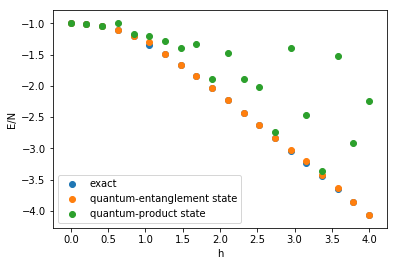

In [258]:
# Finally, let's put all results together
mine_=np.array(mine)/4
q_ent_mine_=np.array(q_ent_mine)/4
q_prod_mine_=np.array(q_prod_mine)/4
plt.scatter(np.linspace(0,4,20), mine_, label='exact')
plt.scatter(np.linspace(0,4,20), q_mine_, label='quantum-entanglement state')
plt.scatter(np.linspace(0,4,20),q_prod_mine_, label='quantum-product state')
plt.xlabel('h')
plt.ylabel('E/N')
plt.legend()

For VQE, the choice of initial wave function is essential and relies on the understanding of the problem. In this example, we show that the results of the entanglement state match with the exact solution, while the results of the product state deviate. It suggests that four qubits are entangled in the ground state. For further exploration, one can change the types of entanglement and optimizer to see how the results are affectd. 